In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Import các thư viện cần thiết**

In [ ]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


**2. Đọc file dữ liệu VPB và chia dataset theo tỉ lệ 6:3:1**

In [ ]:
# Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/StockData/VPB.csv')

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

**Xem** **lại** **dataset**

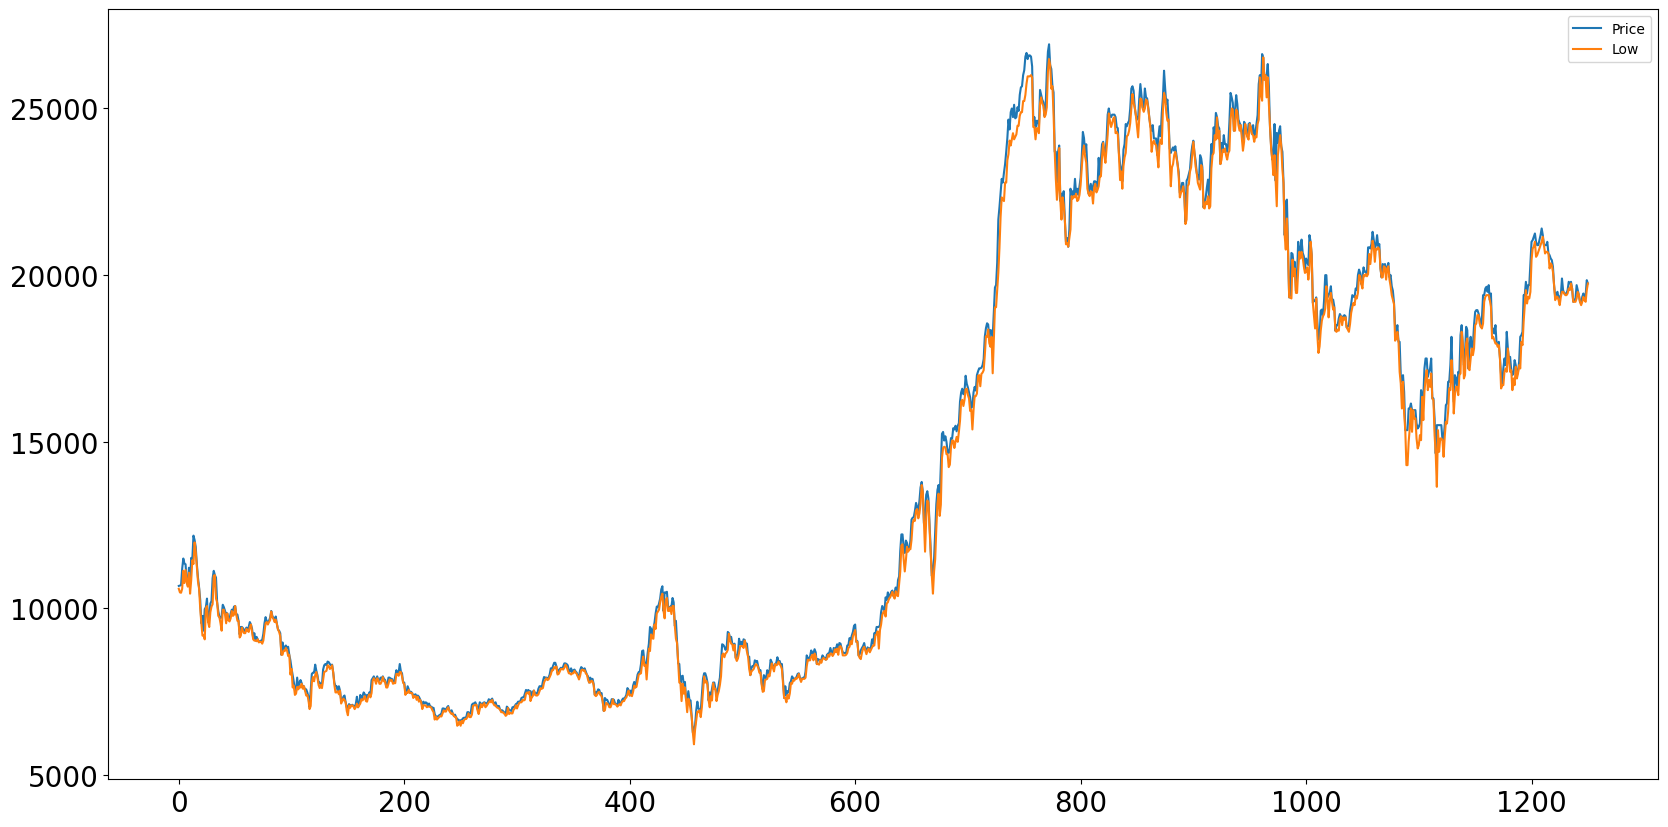

In [ ]:
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

***Tìm m thích hợp***

In [ ]:
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-1.0092114971561106,
 0.7498898098466933,
 23,
 1227,
 {'1%': -3.435690695421723,
  '5%': -2.863898416697677,
  '10%': -2.5680256555204184},
 17822.00618770349)

In [ ]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [ ]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-6.764614757025684,
 2.7371502262804035e-09,
 22,
 1227,
 {'1%': -3.435690695421723,
  '5%': -2.863898416697677,
  '10%': -2.5680256555204184},
 17807.55746247881)

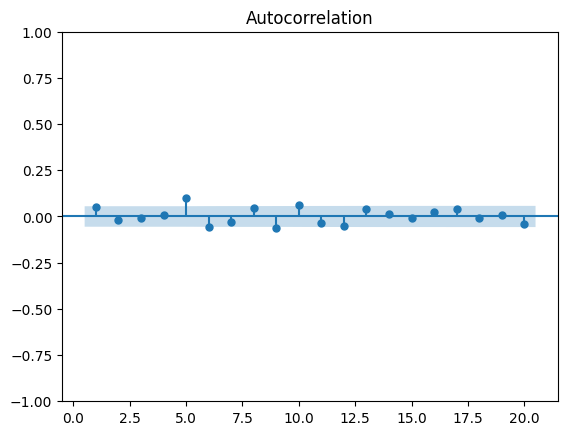

In [ ]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

**3. Dùng auto_arima để tìm model thích hợp**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df

,Price,Low
0,10676.9,10590.4
1,10687.7,10482.4
2,10698.5,10471.6
3,11195.6,10590.4
4,11498.2,11130.8
...,...,...
1246,19450.0,19350.0
1247,19300.0,19250.0
1248,19400.0,19200.0
1249,19850.0,19550.0


In [ ]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[5]             : AIC=10297.491, Time=2.97 sec
 ARIMA(0,2,0)(0,0,0)[5]             : AIC=10690.682, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[5]             : AIC=10524.813, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[5]             : AIC=10303.907, Time=0.68 sec
 ARIMA(2,2,2)(0,0,1)[5]             : AIC=10295.541, Time=1.14 sec
 ARIMA(2,2,2)(0,0,0)[5]             : AIC=10293.550, Time=0.56 sec
 ARIMA(2,2,2)(1,0,0)[5]             : AIC=10295.546, Time=2.30 sec
 ARIMA(1,2,2)(0,0,0)[5]             : AIC=10290.955, Time=1.19 sec
 ARIMA(1,2,2)(1,0,0)[5]             : AIC=10292.951, Time=2.26 sec
 ARIMA(1,2,2)(0,0,1)[5]             : AIC=10292.951, Time=4.23 sec
 ARIMA(1,2,2)(1,0,1)[5]             : AIC=10294.954, Time=3.50 sec
 ARIMA(0,2,2)(0,0,0)[5]             : AIC=10290.876, Time=0.47 sec
 ARIMA(0,2,2)(1,0,0)[5]             : AIC=10292.864, Time=1.02 sec
 ARIMA(0,2,2)(0,0,1)[5]             : AIC=10292.865, Time=1.69 sec
 ARIMA(0,2,2)(1,0,1

**Dùng SARIMAX để train model**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(0,2,3), seasonal_order=(0, 0, 0, 5))
model_fit = model1.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**4. Quá trình test**

In [ ]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([25222.5, 25407.7, 25741. , 25963.3, 25963.3, 25963.3, 26000.3,
       25926.2, 24444.7, 24444.7, 24074.3, 24407.7, 24407.7, 24259.5,
       25148.4, 25333.6, 25148.4, 25074.4, 24741. , 24815.1, 25037.3,
       26111.4, 26481.8, 26296.6, 25592.9, 25667. , 24815.1, 23704. ,
       22889.1, 22259.5, 22592.8, 23815.1, 22222.5, 21666.9, 22333.6,
       22111.4, 21666.9, 20926.2, 20963.2, 20852.1, 21111.4, 21370.6,
       22370.6, 22296.5, 22370.6, 22333.6, 22444.7, 22222.5, 22259.5,
       22407.7, 22704. , 23222.5, 23666.9, 23889.2, 23555.8, 23370.6,
       22592.8, 22444.7, 22370.6, 22518.8, 22481.7, 22148.4, 22629.9,
       22741. , 22481.7, 22555.8, 22666.9, 22963.2, 22963.2, 23555.8,
       23963.2, 23592.9, 23370.6, 23778. , 24222.5, 24852.1, 24629.9,
       24444.7, 24555.8, 24704. , 24741. , 24259.5, 24296.6, 24222.5,
       23592.9, 22852.1, 23111.4, 22592.8, 23266.7, 23533.3, 23666.7,
       24166.7, 24200. , 24333.3, 24566.7, 25000. , 25433.3, 25166.7,
       25033.3, 2480

**5. Quá trình validate**

In [ ]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
exg = np.array(val_data['Low'])
y_pred_val = model_fit.predict(start=len(x_train), end = len(x_train)+ len(y_val)-1, exog=exg)
y_pred_val

array([15550., 15900., 16600., 16550., 17450., 16900., 15850., 16400.,
       16650., 16650., 16400., 17000., 17050., 18300., 17950., 16900.,
       17000., 17950., 18100., 17200., 17150., 17500., 17800., 17600.,
       17800., 18500., 18550., 18800., 18800., 18550., 18450., 18400.,
       18550., 19200., 19350., 19400., 19400., 19400., 19250., 19050.,
       18100., 18150., 18050., 17950., 17950., 17850., 17900., 17500.,
       16600., 16700., 16700., 17100., 17200., 17100., 17800., 17450.,
       17100., 17150., 16550., 16900., 16700., 17250., 16900., 17050.,
       17300., 17200., 18000., 17900., 18600., 19100., 19550., 19150.,
       19350., 19300., 19500., 20450., 20800., 20850., 21000., 20550.,
       20600., 20700., 20800., 20900., 21000., 21150., 20900., 20650.,
       20700., 20700., 20650., 20200., 20350., 20300., 20100., 19700.,
       19250., 19350., 19350., 19250., 19100., 19350., 19500., 19500.,
       19450., 19400., 19400., 19450., 19600., 19550., 19750., 19600.,
      

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [ ]:
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị low 30 ngày tiếp theo
low_next_30_days = ln_model.predict(x_next_30_days)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=low_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[16784.20126458 16792.63827701 16801.07528945 16809.51230188
 16817.94931431 16826.38632675 16834.82333918 16843.26035161
 16851.69736405 16860.13437648 16868.57138892 16877.00840135
 16885.44541378 16893.88242622 16902.31943865 16910.75645108
 16919.19346352 16927.63047595 16936.06748838 16944.50450082
 16952.94151325 16961.37852568 16969.81553812 16978.25255055
 16986.68956298 16995.12657542 17003.56358785 17012.00060028
 17020.43761272 17028.87462515]


***7.Đánh giá độ chính xác thuật toán***

In [ ]:
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 372.8376811803449
Testing RMSE: 459.64757914442816
Validation MAPE: 1.427321954331313
Testing MAPE: 1.4979691675907685
Validation MAE: 265.87301587301585
Testing MAE: 321.82933333333335


**8. Vẽ biểu đồ**

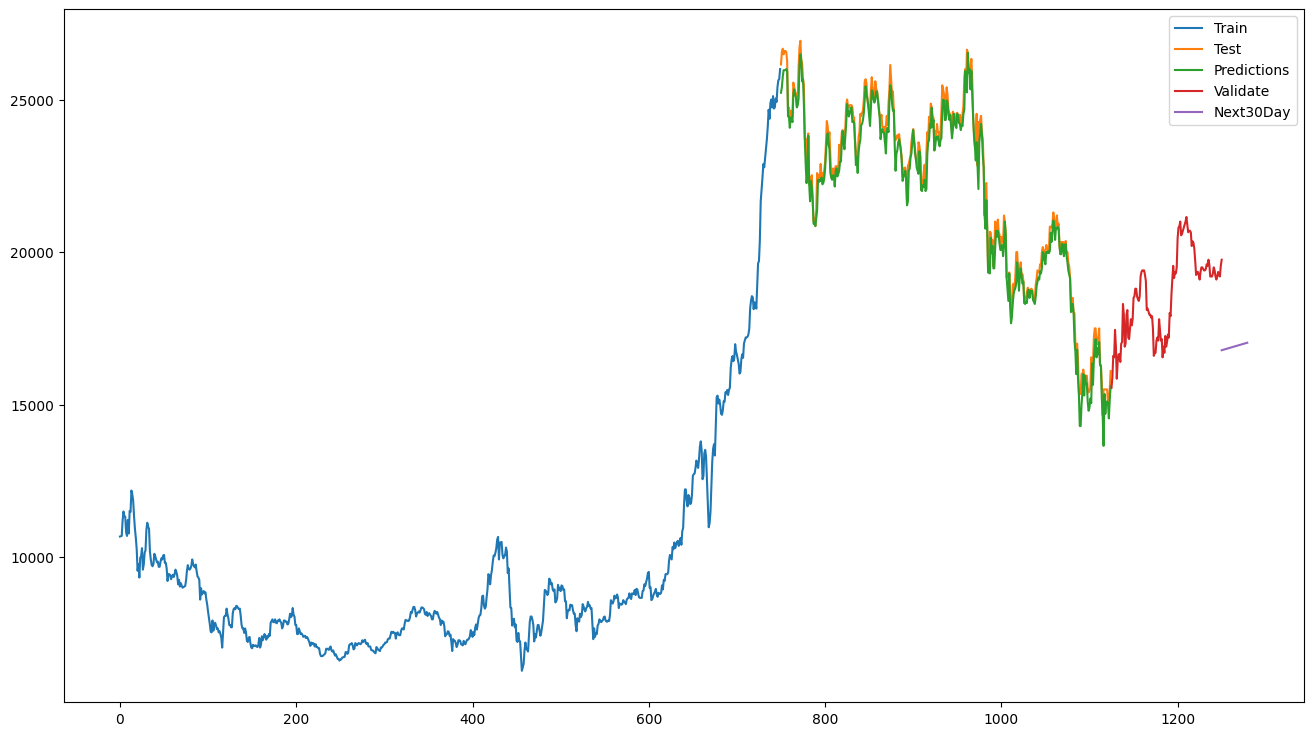

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()